## 1D Advection

In [8]:
import h5py

path = "/home/cmu/anthony/data_gen/pde_data/advection_1024.h5"
f = h5py.File(path, 'r')

In [13]:
data=f['Advection_tensor(1.0992)']

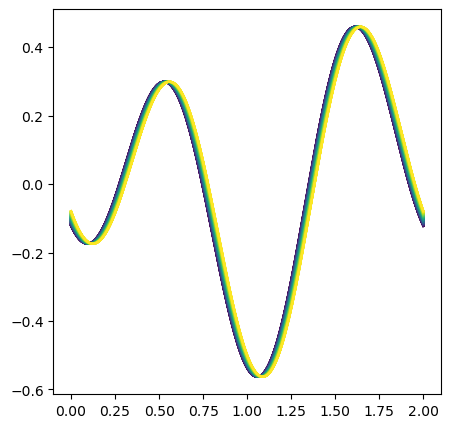

In [14]:
from utils import vis_1D
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
rollout = data['pde_250-200'][0]
vis_1D(rollout, ax)

## 2D Advection

In [9]:
import numpy
import torch
import scipy.io
from utils import RandomSin

seed = 1
nx = 256
ny = 256
cx = 0.1
cy = 0.1

TOTAL_TIME = 2
SAVE_STEPS = 100

dt = TOTAL_TIME/SAVE_STEPS
nt = int(numpy.ceil(TOTAL_TIME/dt))

x = numpy.linspace(-1, 1, nx)
y = numpy.linspace(-1, 1, ny)

# Generate initial Gaussian pulse
adv_fn = RandomSin((nx, ny))

grid = numpy.meshgrid(x, y)
u = torch.Tensor(adv_fn.sample(grid=grid, seed=seed))
u0 = u.clone()

all_us = torch.empty((nt, nx, ny))
all_vs = torch.empty((nt, nx, ny))
times = torch.empty(nt)

for n in range(1, nt+1): ##loop across number of time steps
    x_adv = -dt*n*cx
    y_adv = -dt*n*cy

    # Make new grid and subtract c*t
    new_x = x - x_adv
    new_y = y - y_adv
    new_grid = numpy.meshgrid(new_x, new_y)

    # Sample function at new grid
    new_u = torch.Tensor(adv_fn.sample(grid=new_grid, seed=seed))
    
    all_us[n-1] = new_u.clone()
    times[n-1] = TOTAL_TIME*(n)/nt

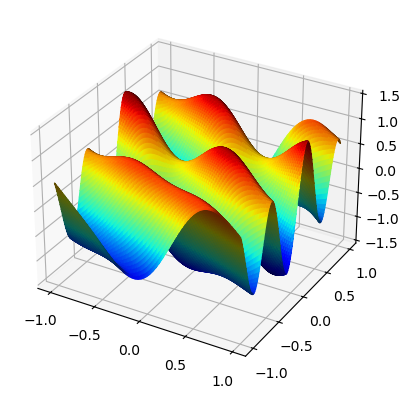

In [10]:
from utils import vis_2d_plot

vis_2d_plot(all_us, grid, f"advection{cx}_{cy}", downsample=2)

In [40]:
import h5py

path = "/home/cmu/anthony/data_gen/pde_data/2d_adv_1024ns_256nx_256ny_0.1_2.5_c.h5"
f = h5py.File(path, 'r')
data = f["0.6132_1.0028"]
u = data['u']
grid = data["grid"]

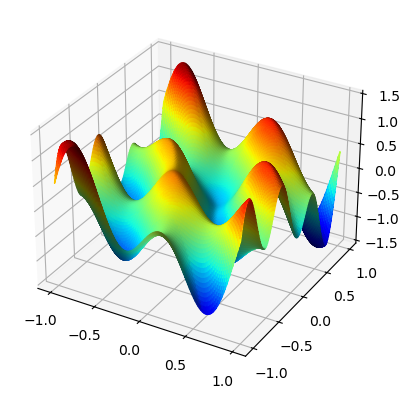

In [41]:
from utils import vis_2d_plot

vis_2d_plot(u, grid, "advection_0.6_1.0", downsample=2)

## 2D Heat

In [5]:
# Define constants
import numpy as np
import torch
from utils import RandomSin
SAVE_STEPS = 100
TOTAL_TIME = 2
nx = 256
ny = 256
idx = 1
nu = 3e-3
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
dt = 0.0001

nt = int(TOTAL_TIME/dt)
if(nu*dt/(dx**2) >= 0.5):
    raise ValueError("Unstable Simulation.")
SAVE_EVERY = int(nt/SAVE_STEPS)

###########################################
# Define domain and solutions
x = np.linspace(-1, 1, nx)
y = np.linspace(-1, 1, ny)
grid = np.meshgrid(x, y)
u = torch.zeros((ny, nx))  
un = np.zeros((ny, nx))

###Assign initial conditions
f = RandomSin((nx, ny))
u = torch.Tensor(f.sample(grid=grid, seed=idx))
u0 = u.clone()
###########################################
all_us = torch.empty((SAVE_STEPS, nx, ny))
times = torch.empty(SAVE_STEPS)

## Save initial condition
all_us[0] = u0
times[0] = 0

for n in range(nt-1): ##loop across number of time steps
    un = u.clone()

    # Calculate finite differences for diffusion term
    diff_ux = (torch.roll(un, shifts=(1), dims=(1)) + torch.roll(un, shifts=(-1), dims=(1)) - 2*un)
    diff_uy = (torch.roll(un, shifts=(1), dims=(0)) + torch.roll(un, shifts=(-1), dims=(0)) - 2*un)
    diff_u = diff_ux + diff_uy

    # Calculate update
    u = nu*dt*diff_u/dx**2 + u

    if((n+1)%SAVE_EVERY == 0):
        all_us[(n+1)//SAVE_EVERY] = u
        times[(n+1)//SAVE_EVERY] = TOTAL_TIME*(n+1)/nt

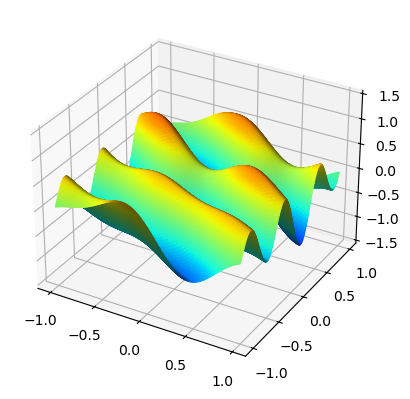

In [6]:
from utils import vis_2d_plot

vis_2d_plot(all_us, grid, f"diffusion_{nu}_{idx}", downsample=2)

In [37]:
import h5py

path = "/home/cmu/anthony/data_gen/pde_data/2d_heat_1024ns_256nx_256ny_0.003_0.02_nu.h5"
f = h5py.File(path, 'r')
data = f["Heat_0.00900909"]
u = data['u']
grid = data["grid"]

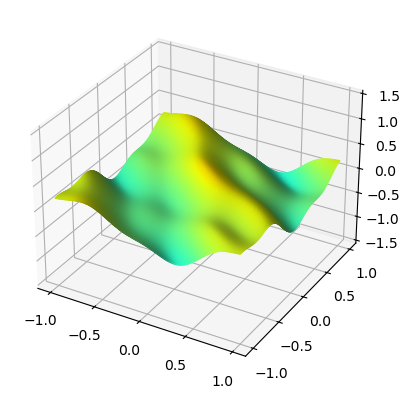

In [38]:
from utils import vis_2d_plot

vis_2d_plot(u, grid, f"diffusion_{0.009}", downsample=2)

## Burgers

In [17]:
nx = 256
ny = 256

nu = 0.01
cx = 1 # fix nonlinear advection
cy = 1

dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .01
dt = sigma*dx*dy/nu

In [19]:
dt = 1e-5
nt = int(TOTAL_TIME/dt)
SAVE_EVERY = nt//SAVE_STEPS

In [109]:
import numpy as np
import torch
from utils import RandomSin
from tqdm import tqdm

idx = 1
nx = 512
ny = 512
SAVE_STEPS = 100
TOTAL_TIME = 2

nu = 0.0075 # diffusion coefficient
cx = -1 # fix nonlinear advection
cy = -1

dx = 2 / (nx - 1)
dy = 2 / (ny - 1)

dt = 5e-5
nt = int(TOTAL_TIME/dt)
SAVE_EVERY = nt//SAVE_STEPS

x = np.linspace(-1, 1, nx)
y = np.linspace(-1, 1, ny)
grid = np.meshgrid(x, y)

u = torch.zeros((ny, nx))  
v = torch.zeros((ny, nx))
un = np.zeros((ny, nx))
vn = np.zeros((ny, nx))

###Assign initial conditions
f = RandomSin((nx, ny))
u = torch.Tensor(f.sample(grid=grid, seed=idx))
v = torch.Tensor(f.sample(grid=grid, seed=idx))
u0 = u.clone()
v0 = v.clone()

#for n in tqdm(range(nt + 1)): ##loop across number of time steps
all_us = torch.empty((SAVE_STEPS, nx, ny))
all_vs = torch.empty((SAVE_STEPS, nx, ny))
times = torch.empty(SAVE_STEPS)

## Save initial condition
all_us[0] = u0
all_vs[0] = v0
times[0] = 0

for n in tqdm(range(nt-1)): ##loop across number of time steps -1 because we already have the initial condition

    # Calculate finite differences
    un = u.clone()
    vn = v.clone()

    # Calculate finite differences for diffusion term
    diff_ux = (torch.roll(un, shifts=(1), dims=(1)) + torch.roll(un, shifts=(-1), dims=(1)) - 2*un)
    diff_uy = (torch.roll(un, shifts=(1), dims=(0)) + torch.roll(un, shifts=(-1), dims=(0)) - 2*un)
    diff_u = diff_ux + diff_uy

    diff_vx = (torch.roll(vn, shifts=(1), dims=(1)) + torch.roll(vn, shifts=(-1), dims=(1)) - 2*vn)
    diff_vy = (torch.roll(vn, shifts=(1), dims=(0)) + torch.roll(vn, shifts=(-1), dims=(0)) - 2*vn)
    diff_v = diff_vx + diff_vy

    # Calculate finite differences for nonlinear advection term
    if(cx <= 0 and cy >= 0):
        adv_u = -cx*un*(un - torch.roll(un, shifts=(-1), dims=(1))) + cy*vn*(un - torch.roll(un, shifts=(1), dims=(0)))
        adv_v = cy*vn*(vn - torch.roll(vn, shifts=(1), dims=(0))) - cx*un*(vn - torch.roll(vn, shifts=(-1), dims=(1)))
    elif(cx >= 0 and cy >= 0):
        adv_u = cx*un*(un - torch.roll(un, shifts=(1), dims=(1))) + cy*vn*(un - torch.roll(un, shifts=(1), dims=(0)))
        adv_v = cy*vn*(vn - torch.roll(vn, shifts=(1), dims=(0))) + cx*un*(vn - torch.roll(vn, shifts=(1), dims=(1)))
    elif(cx <= 0 and cy <= 0):
        adv_u = -cx*un*(un - torch.roll(un, shifts=(-1), dims=(1))) - cy*vn*(un - torch.roll(un, shifts=(-1), dims=(0)))
        adv_v = -cy*vn*(vn - torch.roll(vn, shifts=(-1), dims=(0))) - cx*un*(vn - torch.roll(vn, shifts=(-1), dims=(1)))
    elif(cx >= 0 and cy <= 0):
        adv_u = cx*un*(un - torch.roll(un, shifts=(1), dims=(1))) - cy*vn*(un - torch.roll(un, shifts=(-1), dims=(0)))
        adv_v = -cy*vn*(vn - torch.roll(vn, shifts=(-1), dims=(0))) + cx*un*(vn - torch.roll(vn, shifts=(1), dims=(1)))

    # Calculate update
    u = nu*dt*diff_u/dx**2 - dt*adv_u/dx + u
    v = nu*dt*diff_v/dy**2 - dt*adv_v/dy + v

    if torch.isnan(u).any():
        print("UNSTABLE")
        break

    if((n+1)%SAVE_EVERY == 0):
        all_us[(n+1)//SAVE_EVERY] = u.clone()
        all_vs[(n+1)//SAVE_EVERY] = v.clone()
        times[(n+1)//SAVE_EVERY] = TOTAL_TIME*(n+1)/nt


  0%|          | 0/39999 [00:00<?, ?it/s]

100%|██████████| 39999/39999 [01:56<00:00, 344.45it/s]


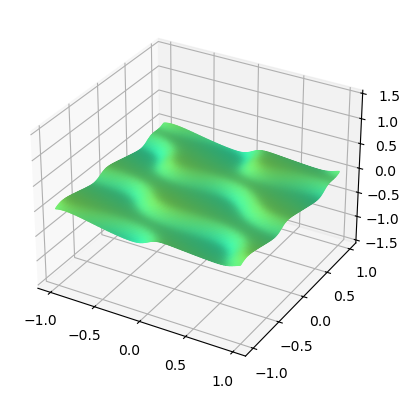

In [110]:
from utils import vis_2d_plot

vis_2d_plot(all_us, grid, f"burgers_{nu}_{idx}_{cx}2ndorder", downsample=4)

In [2]:
import h5py

path = "/home/cmu/anthony/data_gen/pde_data/2d_Burgers_1024ns_256nx_256ny_0.0075_0.015nu_0.5_1.0c.h5"
f = h5py.File(path, 'r')
data = f["Burgers_0.0075_0.9349_0.8131"]
u = data['u']
grid = data["grid"]

In [4]:
grid.shape

(2, 256, 256)

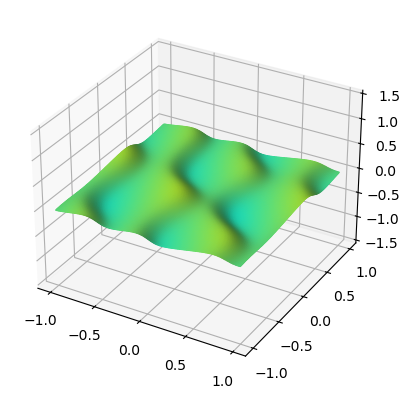

In [5]:
from utils import vis_2d_plot

vis_2d_plot(u, grid, f"Burgers_0.0075_0.9349_0.8131", downsample=2)

In [42]:
def inv_cole_hopf(psi0: np.ndarray, scale: float = 10.) -> np.ndarray:
    """
    Inverse Cole-Hopf transformation to obtain Heat equation out of initial conditions of Burgers' equation.
    Args:
        psi0 (np.ndarray): Burgers' equation (at arbitrary timestep) which gets transformed into Heat equation
        scale (float): scaling factor for transformation
    Returns:
        np.ndarray: transformed Heat equation
    """
    psi0 = psi0 - np.amin(psi0)
    psi0 = scale * 2 * ((psi0 / np.amax(psi0)) - 0.5)
    psi0 = np.exp(psi0)
    return psi0

In [44]:
def fourier_shift(u: torch.Tensor, eps: float=0., dim: int=-1, order: int=0) -> torch.Tensor:
    """
    Shift in Fourier space.
    Args:
        u (torch.Tensor): input tensor, usually of shape [batch, t, x]
        eps (float): shift parameter
        dim (int): dimension which is used for shifting
        order (int): derivative order
    Returns:
        torch.Tensor: Fourier shifted input
    """
    assert dim < 0
    n = u.shape[dim]
    u_hat = torch.fft.rfft(u, dim=dim, norm='ortho')
    # Fourier modes
    omega = torch.arange(n // 2 + 1)
    if n % 2 == 0:
        omega[-1] *= 0
    # Applying Fourier shift according to shift theorem
    fs = torch.exp(- 2 * np.pi * 1j * omega * eps)
    # For order>0 derivative is taken
    fs = (- 2 * np.pi * 1j * omega) ** order * fs
    for _ in range(-dim - 1):
        fs = fs[..., None]
    return torch.fft.irfft(fs * u_hat, n=n, dim=dim, norm='ortho')

In [43]:
def heat_to_burgers(psi: torch.Tensor, nu: float, L: float) -> torch.Tensor:
    """
    Cole-Hopf transformation which transforms a trajectory of the Heat equation into the Burgers' equation.
    Args:
        psi (torch.Tensor): input trajectory of the Heat equation
        nu (float): diffusion coefficient
        L (float): length of spatial domain
    Returns:
        torch.Tensor: Cole-Hopf transformed trajectory of the Burgers' equation
    """
    psi_max = torch.amax(psi, dim=-1, keepdim=True)
    psi_min = torch.amin(psi, dim=-1, keepdim=True)
    psi = psi / (psi_max - psi_min)
    psix = fourier_shift(psi, order=1)
    return -(psix / psi) / (2 * nu)

In [50]:
u0 = all_us[0]
nx = 512
ny = 512
x = np.linspace(-1, 1, nx)
y = np.linspace(-1, 1, ny)
grid = np.meshgrid(x, y)

(-1.5, 1.5)

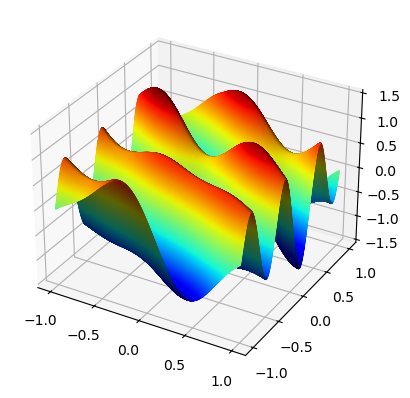

In [51]:
from matplotlib import cm, colors
norm = colors.Normalize()
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
X,Y = grid

x = u0
cmap = cm.jet(norm(x))
ax.plot_surface(X, Y, x, facecolors=cmap, rstride=1, cstride=1)
ax.set_zlim(-1.5, 1.5)

In [65]:
heat = inv_cole_hopf(u0.numpy(), scale = 1.0)

(-2.5, 2.5)

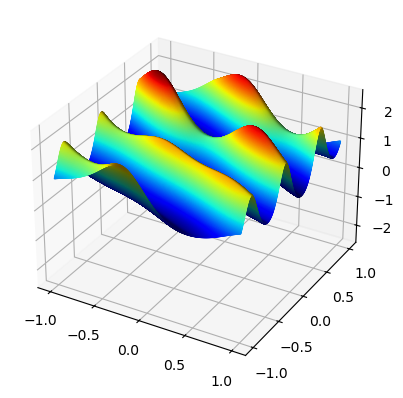

In [66]:
from matplotlib import cm, colors
norm = colors.Normalize()
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
X,Y = grid

x = heat
cmap = cm.jet(norm(x))
ax.plot_surface(X, Y, x, facecolors=cmap, rstride=1, cstride=1)
ax.set_zlim(-2.5, 2.5)

In [69]:
# Define constants
import numpy as np
import torch
SAVE_STEPS = 100
TOTAL_TIME = 2
nx = 512
ny = 512

nu = 0.005
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
dt = 0.0001

nt = int(TOTAL_TIME/dt)
if(nu*dt/(dx**2) >= 0.5):
    raise ValueError("Unstable Simulation.")
SAVE_EVERY = int(nt/SAVE_STEPS)

###########################################
# Define domain and solutions
x_heat = np.linspace(-1, 1, nx)
y_heat = np.linspace(-1, 1, ny)
grid_heat = np.meshgrid(x_heat, y)
u_heat = torch.Tensor(heat)
un_heat = np.zeros((ny, nx))


###########################################
all_us_heat = torch.empty((SAVE_STEPS, nx, ny))

## Save initial condition
all_us_heat[0] = u_heat
for n in range(nt-1): ##loop across number of time steps
    un_heat = u_heat.clone()

    # Calculate finite differences for diffusion term
    diff_ux = (torch.roll(un_heat, shifts=(1), dims=(1)) + torch.roll(un_heat, shifts=(-1), dims=(1)) - 2*un_heat)
    diff_uy = (torch.roll(un_heat, shifts=(1), dims=(0)) + torch.roll(un_heat, shifts=(-1), dims=(0)) - 2*un_heat)
    diff_u = diff_ux + diff_uy

    # Calculate update
    u_heat = nu*dt*diff_u/dx**2 + u_heat

    if((n+1)%SAVE_EVERY == 0):
        all_us_heat[(n+1)//SAVE_EVERY] = u_heat

In [73]:
all_us_heat.shape

torch.Size([100, 512, 512])

In [77]:
grid[0].shape

(512, 512)

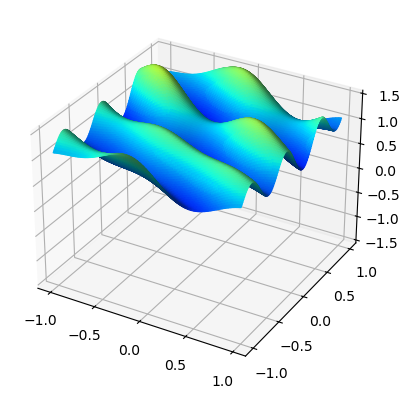

In [78]:
from utils import vis_2d_plot

vis_2d_plot(all_us_heat, grid, f"heat_inverse_colehopf{nu}", downsample=4)

In [81]:
burgers = heat_to_burgers(all_us_heat, nu, 2)

In [82]:
burgers.shape

torch.Size([100, 512, 512])

In [84]:
burgers[-1]

tensor([[64.5280, 62.7080, 60.9199,  ..., 70.1681, 68.2591, 66.3787],
        [63.6766, 61.8452, 60.0460,  ..., 69.3531, 67.4316, 65.5391],
        [62.6866, 60.8441, 59.0341,  ..., 68.3986, 66.4649, 64.5605],
        ...,
        [66.2283, 64.4438, 62.6900,  ..., 71.7549, 69.8851, 68.0425],
        [65.8059, 64.0094, 62.2440,  ..., 71.3709, 69.4878, 67.6324],
        [65.2384, 63.4301, 61.6533,  ..., 70.8414, 68.9452, 67.0772]])

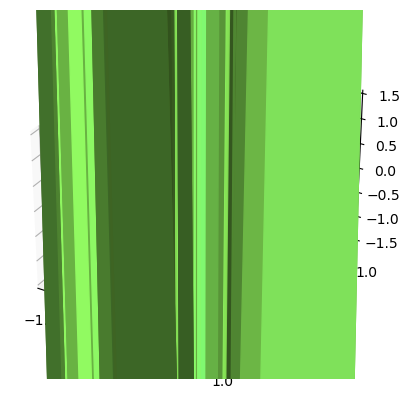

In [86]:
from utils import vis_2d_plot

vis_2d_plot(burgers, grid, f"burgers_cole_hopf{nu}", downsample=4)

## Gaussian Random Field

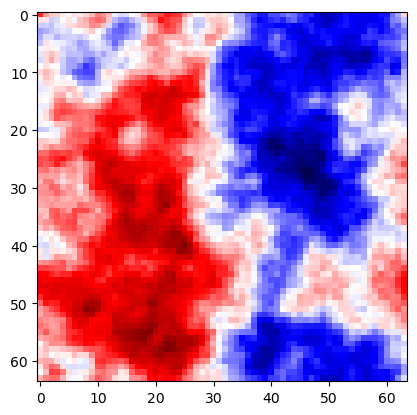

In [31]:
from FyeldGenerator import generate_field
import matplotlib.pyplot as plt
import numpy as np

# Helper that generates power-law power spectrum
def Pkgen(n):
    def Pk(k):
        return np.power(k, -n)

    return Pk


# Draw samples from a normal distribution
def distrib(shape):
    a = np.random.normal(loc=0.1, scale=1, size=shape)
    b = np.random.normal(loc=0.1, scale=1, size=shape)
    return a + 1j * b


shape = (64, 64)

field = generate_field(distrib, Pkgen(3.5), shape)

plt.imshow(field, cmap="seismic")